# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.model_selection import GridSearchCV

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Load feature names.

In [2]:
feature_names = []
with open('Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print (train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

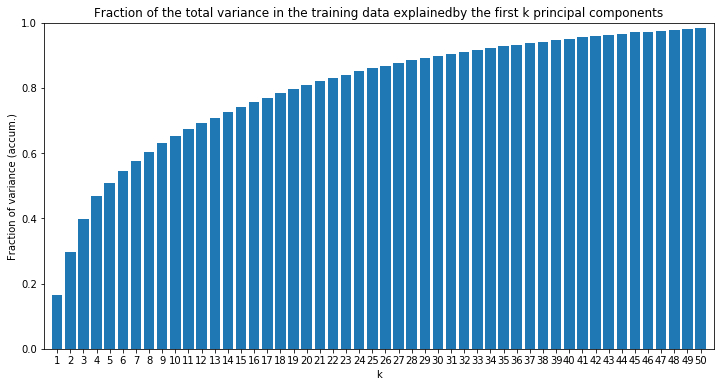

In [4]:

def P1():
    k_values = []
    variance_ratio = []
    for i in range(1,51):
        pca_mod = PCA(n_components = i)
        pca_mod.fit(train_data)
        k_values.append(i)
        variance_ratio.append(np.cumsum(pca_mod.explained_variance_ratio_)[-1])
    plt.figure(figsize=(12, 6))
    plt.bar(k_values,variance_ratio,align='center') # A bar chart
    plt.title('Fraction of the total variance in the training data explained'\
              'by the first k principal components')
    plt.xticks(np.arange(1,51), np.array([str(i) for i in np.arange(1,51)]))
    plt.xlabel('k')
    plt.ylabel('Fraction of variance (accum.)')
    plt.axis([0, 51, 0, 1])
    
P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

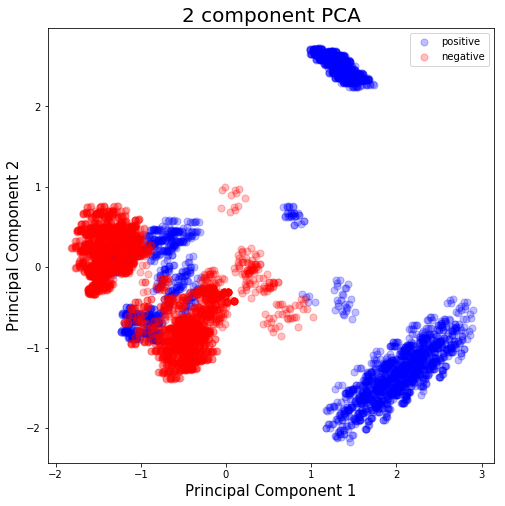

In [5]:
def P2():
    n_comp = 2
    pca_mod = PCA(n_components = n_comp)
    principalComponents = pca_mod.fit_transform(train_data)
    
    
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    
    principalDf['target'] = train_labels.tolist()
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1,0]
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['target'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color, alpha = 0.25
                   , s = 50)
    ax.legend(['positive','negative'])
   
    
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

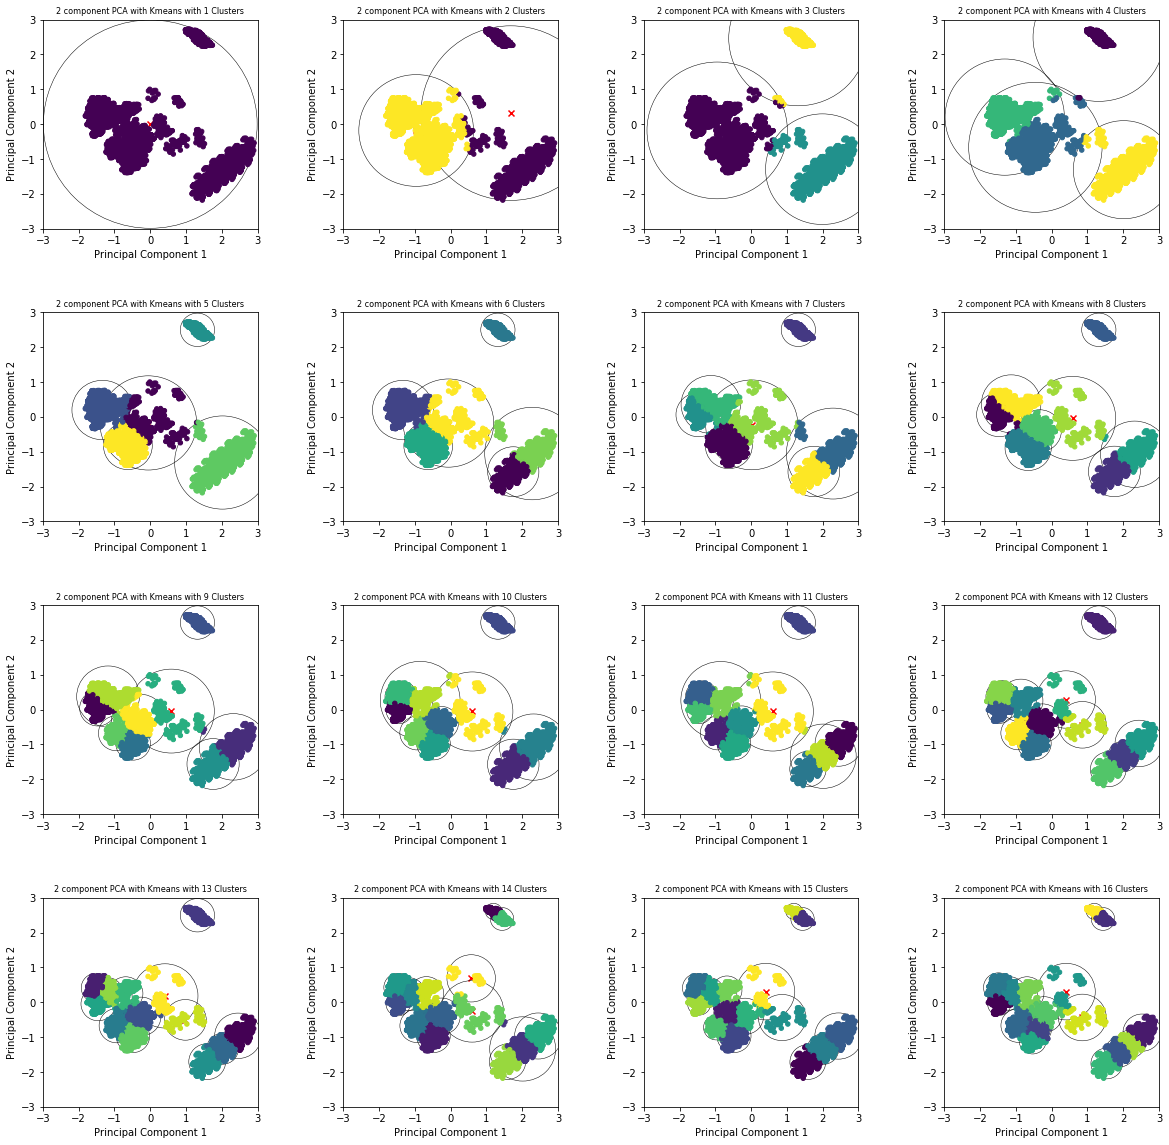

In [6]:
def P3():
    n_comp = 2
    pca_mod = PCA(n_components = n_comp)
    reduced_train_data = pca_mod.fit_transform(train_data)
    fig = plt.figure(figsize = (20,20))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1, 17):
        KM = KMeans(n_clusters=i)
        KM.fit(reduced_train_data)
        ax = fig.add_subplot(4, 4, i)
        ax.set_xlabel('Principal Component 1', fontsize = 10)
        ax.set_ylabel('Principal Component 2', fontsize = 10)
        ax.set_title('2 component PCA with Kmeans with '+ str(i) + ' Clusters', fontsize = 8)
        
        ax.scatter(reduced_train_data[:, 0], reduced_train_data[:, 1],c=KM.labels_.astype(float)
                   , s = 20,  cmap='viridis', zorder=2)
        centroids = KM.cluster_centers_
        # Plot the centroids as a red X
        ax.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', color='r')
        plt.xlim([np.floor(reduced_train_data.min()), np.ceil(reduced_train_data.max())])
        plt.ylim([np.floor(reduced_train_data.min()), np.ceil(reduced_train_data.max())])   
        
        for ind,i in enumerate(centroids):
            class_inds=np.where(KM.labels_==ind)[0]
            max_dist=np.max(metrics.euclidean_distances(i.reshape(1, -1), reduced_train_data[class_inds]))
            fig.gca().add_artist(plt.Circle(i, max_dist,facecolor='None',
                     linewidth=0.5, fill=False, clip_on=True))
        
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

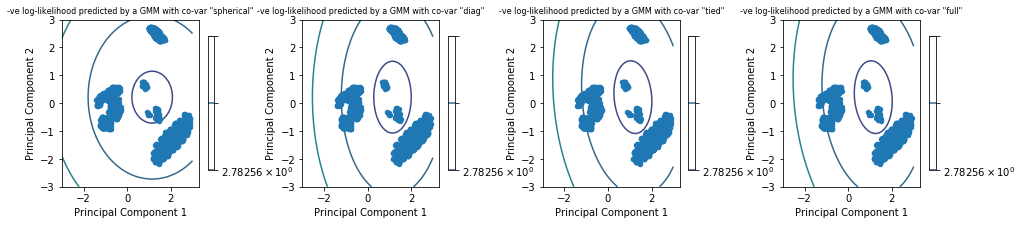

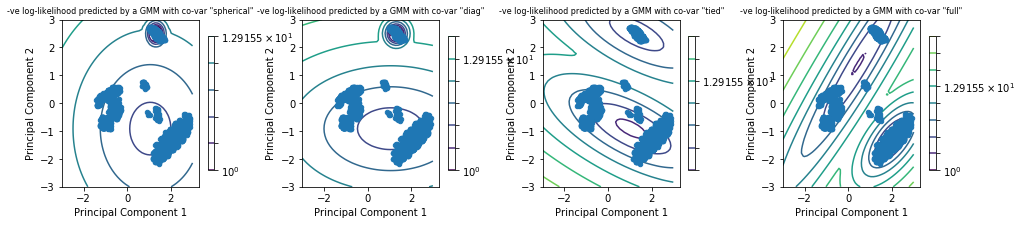

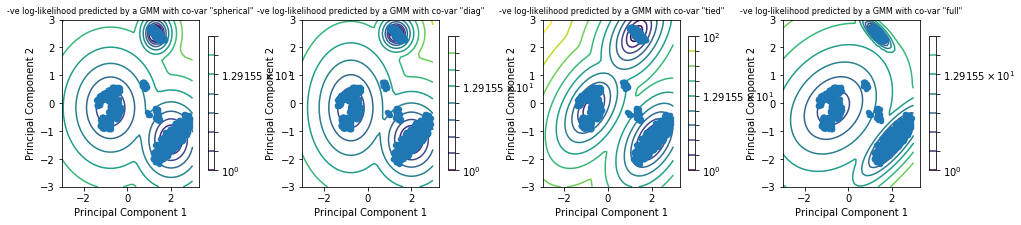

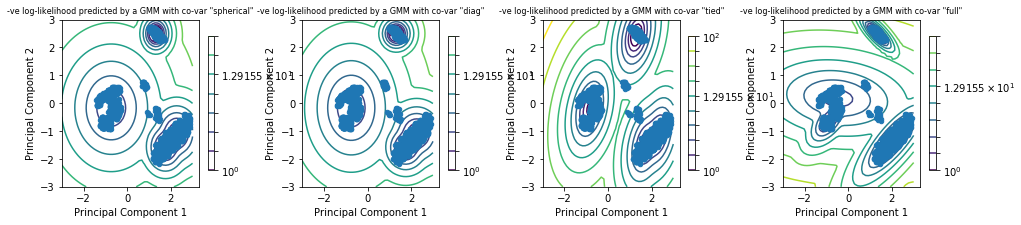

In [7]:
def P4():
    n_comp = 2
    pca_mod = PCA(n_components = n_comp)
    principalComponents = pca_mod.fit_transform(train_data)
    test_principalComponents = pca_mod.fit_transform(test_data)
    
    indicesToKeep = np.where(train_labels == 1)
    
    positive_PrincipalComponents = principalComponents[indicesToKeep]
   
    cov_matrix_type = ['spherical', 'diag', 'tied', 'full']
   
    for i in range(1,5):
        fig = plt.figure(figsize = (16,16))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for p,j in zip(range(len(cov_matrix_type)),cov_matrix_type):
            gmm = GaussianMixture(n_components=i, covariance_type=j).fit(positive_PrincipalComponents)
            ax = fig.add_subplot(4, 4, p+1)
            # display predicted scores by the model as a contour plot
            x = np.linspace(-3.0, 3.0)
            y = np.linspace(-3.0, 3.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 2, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            ax.set_xlabel('Principal Component 1', fontsize = 10)
            ax.set_ylabel('Principal Component 2', fontsize = 10)
            ax.scatter(positive_PrincipalComponents[:, 0], positive_PrincipalComponents[:, 1], s = 20,  cmap='viridis', zorder=2)

            ax.set_title('-ve log-likelihood predicted by a GMM with co-var "'+ j+'"', fontsize = 8)
            ax.axis('tight')

    
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [18]:
def P5():
    n_comp = 2
    pca_mod = PCA(n_components = n_comp)
    principalComponents = pca_mod.fit_transform(train_data)
    test_principalComponents = pca_mod.transform(test_data)
    
    indicesToKeep = np.where(train_labels == 1)
    
    positive_PrincipalComponents = principalComponents[train_labels == 1 ]
    negative_PrincipalComponents = principalComponents[train_labels == 0 ]
    
    gmm_positive = GaussianMixture(n_components=4, covariance_type='full',random_state =0).fit(positive_PrincipalComponents)
    gmm_negative = GaussianMixture(n_components=4, covariance_type='full',random_state =0).fit(negative_PrincipalComponents)
    
    scores_positive = gmm_positive.score_samples(test_principalComponents)
    scores_negative = gmm_negative.score_samples(test_principalComponents)
    
    label_list=[]

    for i in range(0,len(test_principalComponents)):#append the label based on score
    #for i in range(0,10):
        poison=gmm_positive.score([test_principalComponents[i]])
        #print(poison)#delete
        nonpoison=gmm_negative.score([test_principalComponents[i]])
        #print(nonpoison)#delete
        if poison>nonpoison:
            label_list.append(1)
        else:
            label_list.append(0)
    #print(label_list[0:10])
            
    accuracy=[]
    count = 0
    for i in range (0, len(label_list)):
        if label_list[i]==test_labels[i]:
            accuracy.append(1)
        else:
            accuracy.append(0)
    print("The accuracy is",sum(accuracy)/len(accuracy))  
    
    predictions = np.where(scores_positive >= scores_negative, 1, 0)
    
    print ('The accuracy is {0:.2f}%'.format(100*metrics.accuracy_score(test_labels, predictions)))
    
    pca=PCA(2)#instantiate a PCA
    projected=pca.fit_transform(train_data) #fit the training data
    poison_index=np.where(train_labels==1) #find index for poison mushroom
    non_poison_index=np.where(train_labels==0)#find index for non-poison mushroom
    
    #append all coordinates of poison/nonpoison mushroom
    projected_poison=[] 
    projected_nonpoison=[]
    
    for i in range (0,len(poison_index[0])): 
                    projected_poison.append(projected[poison_index[0][i]])
    for i in range (0,len(non_poison_index[0])): 
                    projected_nonpoison.append(projected[non_poison_index[0][i]])
    
    #convert the list to a numpy array
    np_poison=np.array(projected_poison)
    np_nonpoison=np.array(projected_nonpoison)
    
    #Fit two 4-component full covariance GMMs
    clf_poison = GaussianMixture(n_components=4, covariance_type='full')
    clf_poison.fit(np_poison)
    
    clf_nonpoison = GaussianMixture(n_components=4, covariance_type='full')
    clf_nonpoison.fit(np_nonpoison)
    
    proj_test=pca.transform(test_data)
    label_list=[]
    
    for i in range(0,len(proj_test)):#append the label based on score
    #for i in range(0,10):
        poison=clf_poison.score([proj_test[i]])
        #print(poison)#delete
        nonpoison=clf_nonpoison.score([proj_test[i]])
        #print(nonpoison)#delete
        if poison>nonpoison:
            label_list.append(1)
        else:
            label_list.append(0)
    #print(label_list[0:10])
            
    accuracy=[]
    count = 0
    for i in range (0, len(label_list)):
        if label_list[i]==test_labels[i]:
            accuracy.append(1)
        else:
            accuracy.append(0)
    print("The accuracy is",sum(accuracy)/len(accuracy))    
P5()

The accuracy is 0.9501779359430605
The accuracy is 95.02%
The accuracy is 0.9501779359430605


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

**Consider F - features <br>
        &emsp; &emsp;  G - GMM components <br>
        &emsp; &emsp;  C - classes <br>
        &emsp; &emsp;  M - Mean Vector (n features n mean vector) <br>
        &emsp; &emsp;  For 'spherical' the total parameters would be (1 + M) * G * C -> Shperical uses 1 same variance value for each Feature and all co-variances are 0 <br>
        &emsp; &emsp;  For 'diagonal' the total parameters would be (F + M) * G * C -> Different variance for each feature and all co-variances are 0 <br>
        &emsp; &emsp;  For 'tied' the total parameters would be (( F * F ) + ( M * G )) * C -> The upper half is equal to the lower half in the co-variance matrix <br>
        &emsp; &emsp;  For 'full' the total parameters would be ( ( F * F) + M ) * G * C -> Different variance co-variance value for each feature <br>
**

In [9]:
def P6():
    cov_matrix_type = ['spherical', 'diag', 'tied', 'full']
    
    info_objects = []
 
    for cov in cov_matrix_type:
        for pca_comps in range(1,25):
            F=pca_comps
            M=pca_comps
            C=2
            pca_mod = PCA(n_components = pca_comps)
            principalComponents = pca_mod.fit_transform(train_data)

            positive_PrincipalComponents = principalComponents[train_labels == 1 ]
            negative_PrincipalComponents = principalComponents[train_labels == 0 ]         
            test_principalComponents = pca_mod.transform(test_data)
            for gmm_comps in range(1,25):
                G=gmm_comps
                total_params = get_params_count(F,M,G,C,cov) 
                if(total_params <= 50):
                    gmm_positive = GaussianMixture(n_components=gmm_comps, covariance_type=cov,random_state =0).fit(positive_PrincipalComponents)
                    gmm_negative = GaussianMixture(n_components=gmm_comps, covariance_type=cov,random_state =0).fit(negative_PrincipalComponents)
                        
                    scores_positive = gmm_positive.score_samples(test_principalComponents)
                    scores_negative = gmm_negative.score_samples(test_principalComponents)
                    predictions = np.where(scores_positive >= scores_negative, 1, 0)   
                    info_objects.append(Info(F,G,cov,metrics.accuracy_score(test_labels, predictions)))
                   
    info_objects.sort(key=lambda info: info.accuracy)
    best_data = info_objects[-1]
    print (' The BEST accuracy is with pca comps {0} AND for {1} gmms having covairance type {2} is {3:.2f}% '.\
                           format(best_data.pca_comps,best_data.gmm_comps,  best_data.cov, 100*best_data.accuracy))
    
    print('\n\n------------------------------')
    print('\n\n Accuaracies \n\n',
          pd.DataFrame([t.__dict__ for t in info_objects ]))

class Info:
        def __init__(self, pca_comps, gmm_comps, cov, accuracy):
            self.pca_comps = pca_comps
            self.gmm_comps = gmm_comps
            self.cov = cov
            self.accuracy = accuracy
                
def get_params_count(F,M,G,C,cov):
    if cov == 'full':
        return ( ( F * F) + M ) * G * C
    elif cov == 'tied':
        return (( F * F ) + ( M * G )) * C
    elif cov == 'spherical':
        return (1 + M) * G * C
    elif cov == 'diag':
        return (F + M) * G * C
    
P6()

 The BEST accuracy is with pca comps 7 AND for 3 gmms having covairance type spherical is 97.33% 


------------------------------


 Accuaracies 

      accuracy        cov  gmm_comps  pca_comps
0    0.816726       tied          1          4
1    0.816726       full          1          4
2    0.818505       full          2          3
3    0.843416       diag          1          4
4    0.843416       diag          2          4
5    0.844306  spherical          1          1
6    0.844306       diag          1          1
7    0.844306       tied          1          1
8    0.844306       full          1          1
9    0.854982       tied          2          3
10   0.855872  spherical          2          4
11   0.859431       diag          2          3
12   0.860320  spherical          1          2
13   0.862100       diag          1          2
14   0.862100       tied          1          2
15   0.862100       full          1          2
16   0.862989  spherical          1          4
17   